# Feature Selection

In [1]:
import huggingface_hub
import os
from datasets import load_dataset, Dataset


print("Logging in to Hugging Face Hub and W&B...")
huggingface_hub.login(token=os.getenv('HUGGINGFACE_TOKEN'))
print("Login successful.")

Logging in to Hugging Face Hub and W&B...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/bundeli/.cache/huggingface/token
Login successful
Login successful.


## Loading the preprocessed Dataset with the whole Feature Set

In [34]:
huggingface_username = 'HSLU-AICOMP-LearningAgencyLab'
competition = 'learning-agency-lab-automated-essay-scoring-2_V2'

print("Loading the entire dataset from Hugging Face...")
dataset = load_dataset(f"{huggingface_username}/{competition}")
print("Dataset loaded successfully.")

print("Inspecting the dataset...")
print(dataset)
print(dataset['train'][0])

Loading the entire dataset from Hugging Face...
Dataset loaded successfully.
Inspecting the dataset...
DatasetDict({
    train: Dataset({
        features: ['essay_id', 'full_text', 'score', 'unique_mistakes', 'repeated_mistakes_count', 'max_repeated_mistake', 'word_count', 'flesch_reading_ease', 'flesch_kincaid_grade', 'sentence_count', 'average_sentence_length', 'pos_noun_count', 'pos_verb_count', 'pos_adj_count', 'pos_adv_count', 'grammar_error_count', 'syntactic_complexity', 'spelling_mistake_count', 'error_density', 'tfidf_keywords_vector', 'lda_topic_vector', 'keyword_coverage', 'pronoun_usage', 'unique_word_proportion', 'long_word_proportion', 'imagery_word_proportion', 'positive_sentiment_score', 'negative_sentiment_score', 'visual_word_proportion', 'unique_visual_word_proportion', 'average_imagery_score', 'discourse_marker_count', 'neural_coherence_score', 'longformer_sentence_embedding', 'longformer_coherence_score', 'type_token_ratio', 'lexical_diversity', 'vocabulary_maturi

## Correlation Matrix

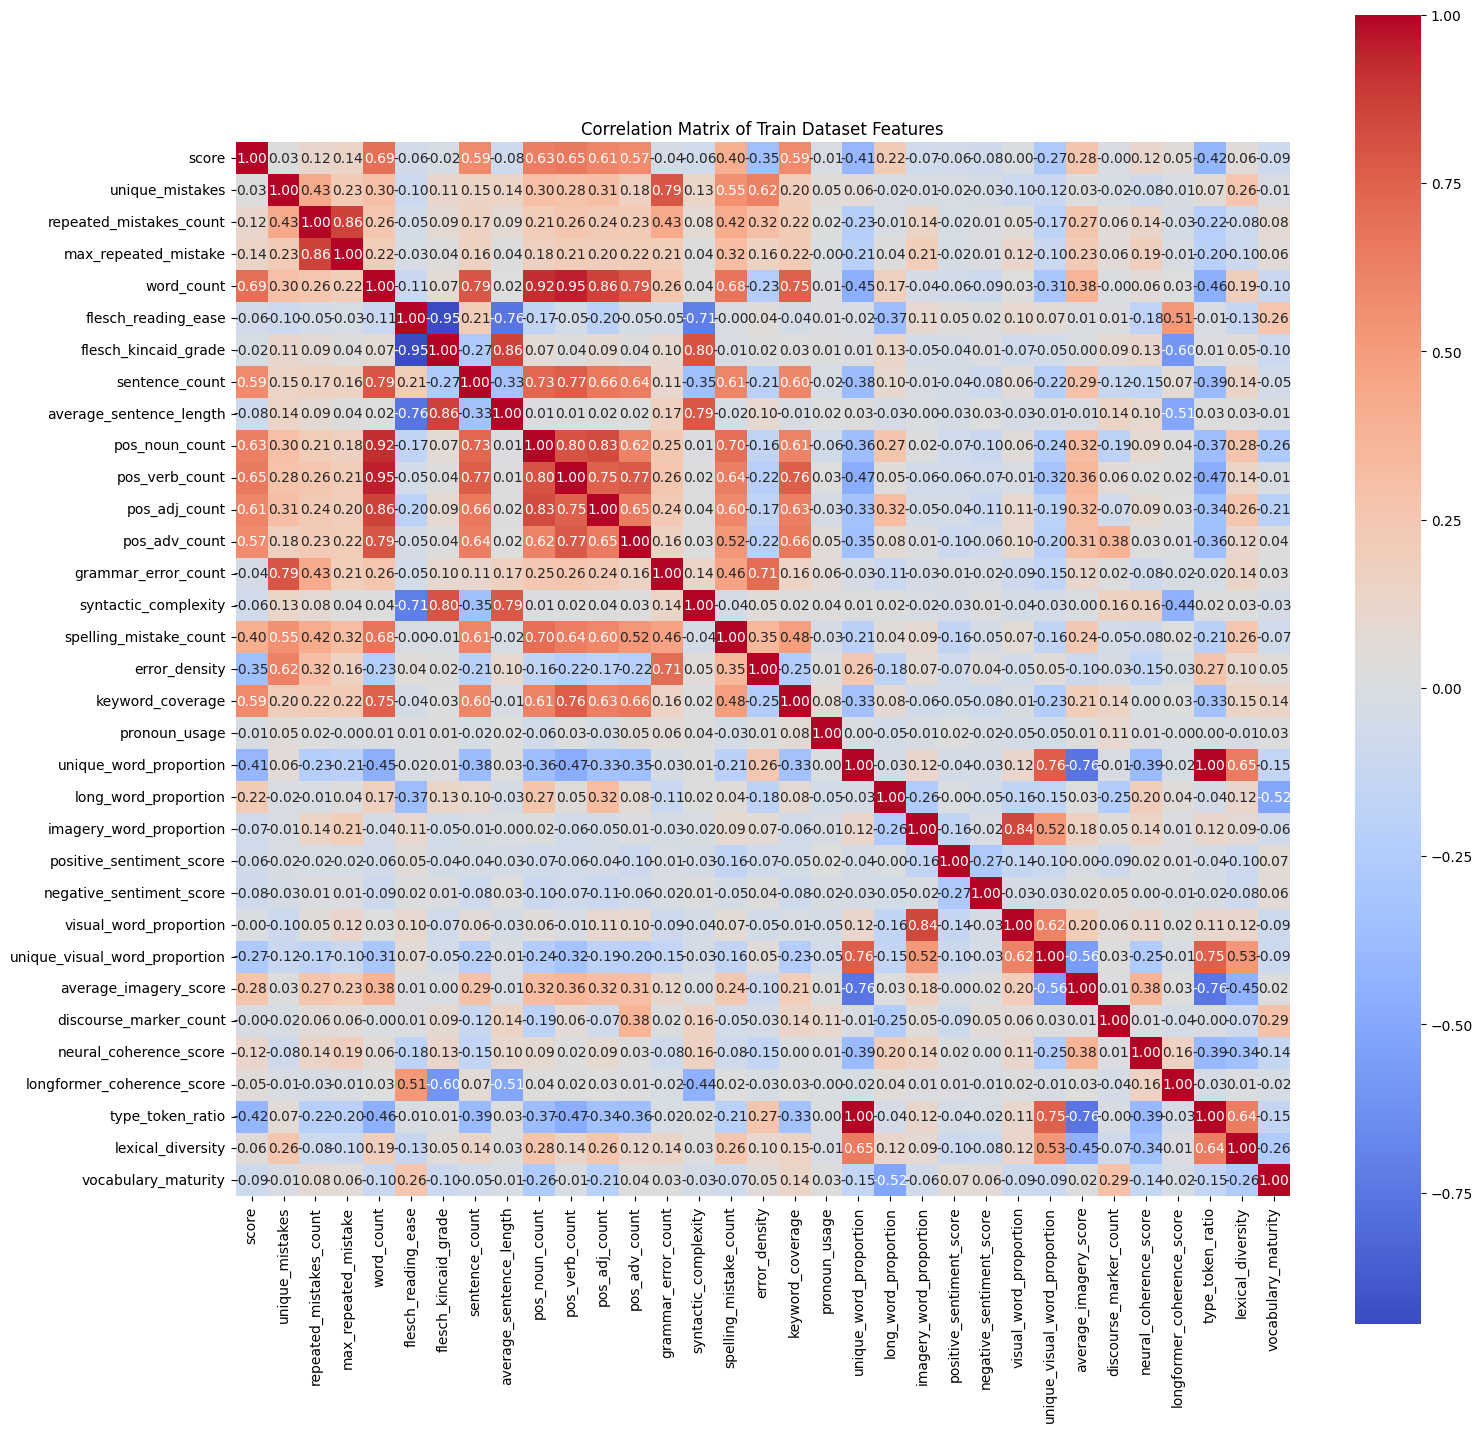

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train_df = pd.DataFrame(dataset['train'])

numerical_features = train_df.select_dtypes(include=[float, int])

correlation_matrix = numerical_features.corr()

plt.figure(figsize=(17, 17))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix of Train Dataset Features")
plt.show()

## Select k-Best
### Prepare features

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from datasets import Dataset, DatasetDict

embedding_columns = ['tfidf_keywords_vector', 'lda_topic_vector', 'longformer_sentence_embedding']
additional_columns = ['essay_id', 'full_text']

numerical_columns = [
    'unique_mistakes', 'repeated_mistakes_count', 'max_repeated_mistake',
    'word_count', 'flesch_reading_ease', 'flesch_kincaid_grade', 'sentence_count',
    'average_sentence_length', 'pos_noun_count', 'pos_verb_count', 'pos_adj_count',
    'pos_adv_count', 'grammar_error_count', 'syntactic_complexity', 'spelling_mistake_count',
    'error_density', 'keyword_coverage', 'pronoun_usage', 'unique_word_proportion',
    'long_word_proportion', 'imagery_word_proportion', 'positive_sentiment_score',
    'negative_sentiment_score', 'visual_word_proportion', 'unique_visual_word_proportion',
    'average_imagery_score', 'discourse_marker_count', 'neural_coherence_score',
    'longformer_coherence_score', 'type_token_ratio', 'lexical_diversity', 'vocabulary_maturity'
]

def apply_select_k_best(X, y, feature_names, score_func, k_values):
    results = {}
    for k in k_values:
        selector = SelectKBest(score_func=score_func, k=k)
        selector.fit(X, y)
        selected_indices = selector.get_support(indices=True)
        selected_features = [feature_names[i] for i in selected_indices]
        results[f"{score_func.__name__}_{k}"] = selected_features
    return results

def create_new_datasets(original_dataset, selected_features_dict, embedding_columns, additional_columns, prefix):
    """
    Creates new datasets with selected features, embeddings, and additional columns for each split.
    Each dataset is assigned to a variable with the format: {prefix}_{k}_dataset
    """
    for key, selected_features in selected_features_dict.items():
        split_dict = {}
        for split in ['train', 'eval', 'test']:
            
            # Extract the selected numerical features and embeddings for the split
            split_data = original_dataset[split]
            selected_data = {col: split_data[col] for col in selected_features}
            for emb_col in embedding_columns:
                selected_data[emb_col] = split_data[emb_col]
            for add_col in additional_columns:
                selected_data[add_col] = split_data[add_col]
            selected_data['score'] = split_data['score'] 

            split_dict[split] = Dataset.from_dict(selected_data)

        # DatasetDict for the current configuration
        dataset_name = f"{prefix}_{key.split('_')[-1]}_dataset"
        globals()[dataset_name] = DatasetDict(split_dict)
        print(f"Created dataset: {dataset_name}")

train_df = pd.DataFrame(dataset['train'])
X_train = train_df[numerical_columns].values
y_train = train_df['score'].values

k_values = [5, 10, 15, 20]

f_classif_results = apply_select_k_best(X_train, y_train, numerical_columns, f_classif, k_values)
mutual_info_results = apply_select_k_best(X_train, y_train, numerical_columns, mutual_info_classif, k_values)

create_new_datasets(dataset, f_classif_results, embedding_columns, additional_columns, "f_classif")
create_new_datasets(dataset, mutual_info_results, embedding_columns, additional_columns, "mutual")

print("\nSelected features with f_classif:")
for key, value in f_classif_results.items():
    print(f"{key}: {value}")

print("\nSelected features with mutual_info_classif:")
for key, value in mutual_info_results.items():
    print(f"{key}: {value}")

Created dataset: f_classif_5_dataset
Created dataset: f_classif_10_dataset
Created dataset: f_classif_15_dataset
Created dataset: f_classif_20_dataset
Created dataset: mutual_5_dataset
Created dataset: mutual_10_dataset
Created dataset: mutual_15_dataset
Created dataset: mutual_20_dataset

Selected features with f_classif:
f_classif_5: ['word_count', 'sentence_count', 'pos_noun_count', 'pos_verb_count', 'pos_adj_count']
f_classif_10: ['word_count', 'sentence_count', 'pos_noun_count', 'pos_verb_count', 'pos_adj_count', 'pos_adv_count', 'spelling_mistake_count', 'keyword_coverage', 'unique_word_proportion', 'type_token_ratio']
f_classif_15: ['max_repeated_mistake', 'word_count', 'sentence_count', 'pos_noun_count', 'pos_verb_count', 'pos_adj_count', 'pos_adv_count', 'spelling_mistake_count', 'error_density', 'keyword_coverage', 'unique_word_proportion', 'long_word_proportion', 'unique_visual_word_proportion', 'average_imagery_score', 'type_token_ratio']
f_classif_20: ['unique_mistakes', '

### Create a Hugging Face Dataset

### Push it to Hugging Face

In [ ]:
repo_id = f"{huggingface_username}/{competition}_SelectKBest"

def push_dataset_to_branch(dataset_dict, repo_id, branch_name):
    """
    Push all splits of a DatasetDict to a specific branch in a repository on Hugging Face Hub.

    Args:
        dataset_dict (DatasetDict): The Hugging Face DatasetDict to upload.
        repo_id (str): The repository ID on Hugging Face Hub.
        branch_name (str): The branch name (e.g., "f_classif_5").
    """
    for split_name in dataset_dict.keys():
        dataset_dict[split_name].push_to_hub(
            repo_id, private=True, split=split_name, revision=branch_name
        )
        print(f"Dataset split '{split_name}' pushed to {repo_id}, branch: {branch_name}")


datasets_to_upload = {
    "f_classif_5": f_classif_5_dataset,
    "f_classif_10": f_classif_10_dataset,
    "f_classif_15": f_classif_15_dataset,
    "f_classif_20": f_classif_20_dataset,
    "mutual_5": mutual_5_dataset,
    "mutual_10": mutual_10_dataset,
    "mutual_15": mutual_15_dataset,
    "mutual_20": mutual_20_dataset,
}

for branch_name, dataset_dict in datasets_to_upload.items():
    print(f"Pushing dataset to branch: {branch_name}")
    push_dataset_to_branch(dataset_dict, repo_id, branch_name)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/bundeli/.cache/huggingface/token
Login successful
Pushing dataset to branch: f_classif_5


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

Dataset split 'train' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: f_classif_5


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/728 [00:00<?, ?B/s]

Dataset split 'eval' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: f_classif_5


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/828 [00:00<?, ?B/s]

Dataset split 'test' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: f_classif_5
Pushing dataset to branch: f_classif_10


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

Dataset split 'train' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: f_classif_10


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/963 [00:00<?, ?B/s]

Dataset split 'eval' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: f_classif_10


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Dataset split 'test' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: f_classif_10
Pushing dataset to branch: f_classif_15


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

Dataset split 'train' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: f_classif_15


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

Dataset split 'eval' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: f_classif_15


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

Dataset split 'test' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: f_classif_15
Pushing dataset to branch: f_classif_20


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

Dataset split 'train' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: f_classif_20


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

Dataset split 'eval' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: f_classif_20


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

Dataset split 'test' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: f_classif_20
Pushing dataset to branch: mutual_5


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

Dataset split 'train' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: mutual_5


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Dataset split 'eval' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: mutual_5


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Dataset split 'test' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: mutual_5
Pushing dataset to branch: mutual_10


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

Dataset split 'train' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: mutual_10


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/964 [00:00<?, ?B/s]

Dataset split 'eval' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: mutual_10


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Dataset split 'test' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: mutual_10
Pushing dataset to branch: mutual_15


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

Dataset split 'train' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: mutual_15


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

Dataset split 'eval' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: mutual_15


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

Dataset split 'test' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: mutual_15
Pushing dataset to branch: mutual_20


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

Dataset split 'train' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: mutual_20


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

Dataset split 'eval' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: mutual_20


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

Dataset split 'test' pushed to HSLU-AICOMP-LearningAgencyLab/learning-agency-lab-automated-essay-scoring-2_V2_SelectKBest, branch: mutual_20


In [50]:
dataset = load_dataset(repo_id, revision="f_classif_10")

print(dataset)

README.md:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/116M [00:00<?, ?B/s]

eval-00000-of-00001.parquet:   0%|          | 0.00/29.2M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13845 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/3462 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['word_count', 'sentence_count', 'pos_noun_count', 'pos_verb_count', 'pos_adj_count', 'pos_adv_count', 'spelling_mistake_count', 'keyword_coverage', 'unique_word_proportion', 'type_token_ratio', 'tfidf_keywords_vector', 'lda_topic_vector', 'longformer_sentence_embedding', 'essay_id', 'full_text', 'score'],
        num_rows: 13845
    })
    eval: Dataset({
        features: ['word_count', 'sentence_count', 'pos_noun_count', 'pos_verb_count', 'pos_adj_count', 'pos_adv_count', 'spelling_mistake_count', 'keyword_coverage', 'unique_word_proportion', 'type_token_ratio', 'tfidf_keywords_vector', 'lda_topic_vector', 'longformer_sentence_embedding', 'essay_id', 'full_text', 'score'],
        num_rows: 3462
    })
    test: Dataset({
        features: ['word_count', 'sentence_count', 'pos_noun_count', 'pos_verb_count', 'pos_adj_count', 'pos_adv_count', 'spelling_mistake_count', 'keyword_coverage', 'unique_word_proportion', 'type_token_ratio',